# Homework 1 - MongoDB
Advanced Information Systems and Big Data - A.Y. 2025-2026

Dataset: Amazon Fine Food Reviews

### Environment

In [1]:
# INSTALL
!pip install pymongo pandas vaderSentiment scikit-learn matplotlib kagglehub -q

# IMPORTS
import kagglehub
import pandas as pd
import numpy as np
from pymongo import MongoClient
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Outputs sentiment scores
from sklearn.feature_extraction.text import TfidfVectorizer # Convert text into numerical vectors
from sklearn.metrics.pairwise import cosine_similarity # Measure similarity between vectors
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import os
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 12.5 MB/s eta 0:00:00


### MongoDB

In [2]:
# MongoDB
!wget -qO - https://www.mongodb.org/static/pgp/server-6.0.asc | sudo apt-key add -
!echo "deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse" | sudo tee /etc/apt/sources.list.d/mongodb-org-6.0.list
!sudo apt-get update -qq
!sudo apt-get install -y mongodb-org > /dev/null 2>&1

# Start SERVER
!mkdir -p /data/db
!mongod --fork --logpath /var/log/mongodb.log --dbpath /data/db # on localhost:27017

# Start CLIENT
client = MongoClient("mongodb://localhost:27017/")

OK
deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse
W: https://repo.mongodb.org/apt/ubuntu/dists/jammy/mongodb-org/6.0/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
about to fork child process, waiting until server is ready for connections.
forked process: 1713
child process started successfully, parent exiting


In [3]:
# DATASET: Amazon Fine Food Reviews
# - 568.454 recensioni di prodotti alimentari
# - Campi: ProductId, UserId, Score (1-5), Summary, Text, Time

path = kagglehub.dataset_download("snap/amazon-fine-food-reviews") # returns a directory path, not the CSV file
CSV_PATH = os.path.join(path, "Reviews.csv") # returns the csv file
df = pd.read_csv(CSV_PATH) # lettura CSV

Using Colab cache for faster access to the 'amazon-fine-food-reviews' dataset.


## Parte 1: Caricamento dei Dati

In [4]:
# STANDARDIZZO i nomi colonne (snake_case)
df = df.rename(columns={
    'ProductId': 'product_id', 'UserId': 'user_id', 'ProfileName': 'profile_name',
    'Score': 'score', 'Summary': 'summary', 'Text': 'text', 'Time': 'time'
})
# CONVERSIONE to_datetime(unit='s'): stringa->timestamp (datetime)
df['time'] = pd.to_datetime(df['time'], unit='s')

print(f"Record: {len(df)}")

Record: 568454


In [5]:
# Lista collezioni usate: 6 collezioni separate per score
COLLECTIONS = ['score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'no_text']

# Pointing to server's database (creating with the first insert_One)
db = client["amazon_reviews"]

In [6]:
# INSERIMENTO DATI CON BATCH LOADING

batches = {c: [] for c in COLLECTIONS}
# per ogni c creo una "coda" temporanea per efficienza di insert

for idx, row in df.iterrows():

    # CREAZIONE documento semi-strutturato (e gestione valori null)
    #   fillna() e controlli NaN prevengono errori su dati mancanti.
    doc = {
        'product_id': str(row['product_id']) if pd.notna(row['product_id']) else '',
        'user_id': str(row['user_id']) if pd.notna(row['user_id']) else '',
        'profile_name': str(row['profile_name']) if pd.notna(row['profile_name']) else '',
        'score': int(row['score']) if pd.notna(row['score']) else 0,
        'summary': str(row['summary']) if pd.notna(row['summary']) else '',
        'text': str(row['text']) if pd.notna(row['text']) else '',
        'time': row['time'] if pd.notna(row.get('time')) else None
    }

    # no_text: documenti senza summary né text (inutilizzabili per analisi)
    if doc['summary'] in ['', 'nan'] and doc['text'] in ['', 'nan']:
        target = 'no_text' # nessun testo -> collezione no_text
    elif 1 <= doc['score'] <= 5:
        target = f"score_{doc['score']}" # score valido (1–5) -> score_1, score_2, …, score_5
    else:
        continue

    batches[target].append(doc)
    if len(batches[target]) >= 5000: # maggiore efficienza di insert_one
        # aggiunge a mongoDB se gli item della lista superano la soglia
        db[target].insert_many(batches[target])
        batches[target] = []

# Inserisce i documenti rimasti nei batch non pieni.
for c, batch in batches.items():
    if batch:
        db[c].insert_many(batch)


print("Documenti per collezione:")
for c in COLLECTIONS:
    print(f"  {c}: {db[c].count_documents({})}")

Documenti per collezione:
  score_1: 52268
  score_2: 29769
  score_3: 42640
  score_4: 80655
  score_5: 363122
  no_text: 0


## Part 2: Sentiment Analysis con VADER

In [12]:
# INIZIALIZZAZIONE ANALIZZATORE VADER
analyzer = SentimentIntensityAnalyzer()

In [13]:
# FUNZIONE DI CLASSIFICAZIONE SENTIMENT
def get_sentiment(text): # Determina il sentiment di una stringa.
    if not text.strip(): # caso test vuoto
        return "neutral"

    c = analyzer.polarity_scores(text)['compound'] # compound = punteggio finale complessivo
    if c >= 0.05: # compound [+0.05, +1]: POSITIVE
        return "positive"
    elif c <= -0.05: # compound [-1, -0.05]: NEGATIVE
        return "negative"
    return "neutral"

In [14]:
# ANALYSIS SENTIMENT SU TUTTE LE RECENSIONI
# Aggiorno ogni documento MongoDB  di ogni collezione con il campo 'sentiment'.

totals = {'positive': 0, 'neutral': 0, 'negative': 0} # Contatore

for coll_name in COLLECTIONS:
    coll = db[coll_name]

    for doc in coll.find(): # return tutti i doc della coll

        text = (doc.get('summary', '') + ' ' + doc.get('text', '')).replace('nan', '') # se i campi sono vuoti, usa ''

        sentiment = get_sentiment(text)
        coll.update_one(
            {'_id': doc['_id']}, # key del doc
            {'$set':
              {'sentiment': sentiment}
            }
        )

        totals[sentiment] += 1

    print(f"{coll_name} completato")


print("\nTotali:")
for s, n in totals.items():
    print(f"  {s}: {n}")

score_1 completato
score_2 completato
score_3 completato
score_4 completato
score_5 completato
no_text completato

Totali:
  positive: 507424
  neutral: 7155
  negative: 53875


## Part 3: Interrogazioni Analitiche

### Query 1

In [7]:
# QUERY 3.1: DISTRIBUZIONE RECENSIONI PER SCORE
print("3.1 Numero di recensioni per score:")

score_counts = {}
for coll_name in COLLECTIONS:

    # count_documents({}) conta tutti i documenti
    count = db[coll_name].count_documents({}) # {} "nessun filtro" (tutti i doc)

    score_counts[coll_name] = count
    print(f" {coll_name}: {count:,} recensioni")

3.1 Numero di recensioni per score:
 score_1: 52,268 recensioni
 score_2: 29,769 recensioni
 score_3: 42,640 recensioni
 score_4: 80,655 recensioni
 score_5: 363,122 recensioni
 no_text: 0 recensioni


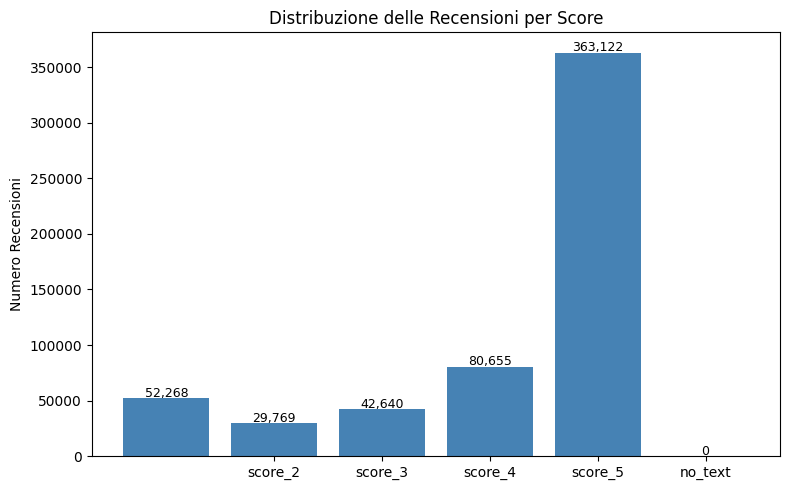

In [8]:
# Visualizzazione con istogramma
plt.figure(figsize=(8, 5))
plt.bar(score_counts.keys(), score_counts.values(), color='steelblue')
plt.ylabel('Numero Recensioni')
plt.title('Distribuzione delle Recensioni per Score')
plt.xticks([1, 2, 3, 4, 5])
# Aggiungo i valori sopra le barre
for score, count in score_counts.items():
    plt.text(score, count + 1000, f'{count:,}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### Query 2

In [9]:
# Raccolgo in un dict per ogni prodotto, numRecensioni e somma degli score

# dizionario basato su key (pid) con due campi
product_stats = defaultdict(lambda: {'total_score': 0, 'num_reviews': 0})

for score in range(1, 6):
    collection_name = f'score_{score}'
    for doc in db[collection_name].find(): # considera tutti i doc della coll
        pid = doc['product_id']
        product_stats[pid]['total_score'] += score
        product_stats[pid]['num_reviews'] += 1

In [10]:
# QUERY 3.2: TOP 5 PRODOTTI PER MEDIA SCORE
print("3.2 Top 5 prodotti per media score:")

top_products = sorted(
    [
        {
            'product_id': pid,
            'avg_score': s['total_score']/s['num_reviews'], # media score
            'num_reviews': s['num_reviews']
        }
        for pid, s in product_stats.items()
    ],
    key=lambda x: (x['avg_score'], x['num_reviews']), reverse=True  # criterio ordinamento
)[:5] # i primi 5


for i, p in enumerate(top_products, 1):
    print(f"  {i}. {p['product_id']} - Media: {p['avg_score']:.2f} ({p['num_reviews']} recensioni)")


3.2 Top 5 prodotti per media score:
  1. B005EL6VOY - Media: 5.00 (33 recensioni)
  2. B000RL53PE - Media: 5.00 (33 recensioni)
  3. B001IZ9ME6 - Media: 5.00 (31 recensioni)
  4. B0029O0XGQ - Media: 5.00 (30 recensioni)
  5. B00376ZEY6 - Media: 5.00 (30 recensioni)


### Query 3

In [11]:
# QUERY 3.3: TOP 5 UTENTI PIÙ ATTIVI (per recensioni)
print("3.3 Top 5 utenti per numero di recensioni:")

user_reviews = {}

for coll_name in COLLECTIONS:
    for doc in db[coll_name].find({}, {'user_id': 1}): # find() con projection (solo colonna userId),
                                                       #        nella projection _id è sempre incluso di default
        uid = doc['user_id']

        if uid not in user_reviews:
            user_reviews[uid] = 0
        user_reviews[uid] += 1

# Ordino per conteggio decrescente
top_users = sorted(user_reviews.items(),
                   key=lambda x: x[1], reverse=True)[:5] # ordina in base a x[1]=numRec

print("\nTop 5 utenti più attivi:")
for i, (user, count) in enumerate(top_users, 1):
    print(f"  {i}. {user}: {count} recensioni")

3.3 Top 5 utenti per numero di recensioni:

Top 5 utenti più attivi:
  1. A3OXHLG6DIBRW8: 448 recensioni
  2. A1YUL9PCJR3JTY: 421 recensioni
  3. AY12DBB0U420B: 389 recensioni
  4. A281NPSIMI1C2R: 365 recensioni
  5. A1Z54EM24Y40LL: 256 recensioni


### Query 4

In [18]:
# QUERY 3.4: DISTRIBUZIONE SENTIMENT PER SCORE

print("3.4 Distribuzione sentiment per score:")

for coll_name in COLLECTIONS:
    coll = db[coll_name]
    # Aggregation pipeline per raggruppare e contare.
    pipeline = [
        {
            '$group': {
                '_id': '$sentiment',    # raggruppa sul sentiment
                'count': {'$sum': 1}    # count = num doc della coll con quel sentiment
            }
        }
    ]

    # aggregate() esegue la pipeline e salva in lista
    # e converto in dizionario per leggibilità (sent:num per ogni sent)
    sentiment_counts = {r['_id']: r['count'] for r in coll.aggregate(pipeline)}

    pos = sentiment_counts.get('positive', 0)
    neu = sentiment_counts.get('neutral', 0)
    neg = sentiment_counts.get('negative', 0)

    total = pos + neu + neg
    total = max(total, 1) # per evitare divisione per 0

    print(f"\n{coll_name}:")
    print(f"  Positive: {pos:,} ({pos/total*100:.1f}%)")
    print(f"  Neutral:  {neu:,} ({neu/total*100:.1f}%)")
    print(f"  Negative: {neg:,} ({neg/total*100:.1f}%)")

3.4 Distribuzione sentiment per score:

score_1:
  Positive: 24,227 (46.4%)
  Neutral:  1,983 (3.8%)
  Negative: 26,058 (49.9%)

score_2:
  Positive: 18,871 (63.4%)
  Neutral:  1,051 (3.5%)
  Negative: 9,847 (33.1%)

score_3:
  Positive: 34,400 (80.7%)
  Neutral:  1,222 (2.9%)
  Negative: 7,018 (16.5%)

score_4:
  Positive: 76,192 (94.5%)
  Neutral:  789 (1.0%)
  Negative: 3,674 (4.6%)

score_5:
  Positive: 353,734 (97.4%)
  Neutral:  2,110 (0.6%)
  Negative: 7,278 (2.0%)

no_text:
  Positive: 0 (0.0%)
  Neutral:  0 (0.0%)
  Negative: 0 (0.0%)


### Query 5

In [21]:
# QUERY 3.5: PRODOTTI CONTROVERSI
# Alto score ma molte recensioni negative

# Aggiungo conteggio sentiment negativi al dict product_stats
for pid in product_stats:
    product_stats[pid]['negative'] = 0

for coll_name in COLLECTIONS:
    for doc in db[coll_name].find({'sentiment': 'negative'}): # per ogni doc
        pid = doc['product_id']
        product_stats[pid]['negative'] += 1


# Filtro prodotti controversi (media >= 4.5, negative >= 10%, min 10 recensioni)
controversial = sorted(
    [
        {
            'product_id': pid,
            'avg_score': s['total_score']/s['num_reviews'],
            'negative_pct': (s['negative']/s['num_reviews'])*100,
            'num_reviews': s['num_reviews']
        }
        for pid, s in product_stats.items()
        if s['num_reviews'] >= 10
            and s['total_score']/s['num_reviews'] >= 4.5
            and s['negative']/s['num_reviews'] >= 0.10
    ],
    key=lambda x: (x['negative_pct'], x['avg_score']), reverse=True # chiave di ordinamento
)

print(f"3.5 Prodotti controversi - Trovati {len(controversial)}:")
for i, p in enumerate(controversial[:5], 1):
    print(f"  {i}. {p['product_id']} - Media: {p['avg_score']:.2f}, Negative: {p['negative_pct']:.1f}%, Reviews: {p['num_reviews']}")

3.5 Prodotti controversi - Trovati 460:
  1. B000FBMFDO - Media: 4.62, Negative: 62.9%, Reviews: 97
  2. B001CDOB40 - Media: 5.00, Negative: 30.8%, Reviews: 13
  3. B000EPOBYC - Media: 4.54, Negative: 30.8%, Reviews: 13
  4. B0007RL9RY - Media: 4.70, Negative: 30.4%, Reviews: 23
  5. B001JU7YJA - Media: 4.50, Negative: 30.0%, Reviews: 10


## Parte 4: Sistema di Raccomandazione

In [30]:
# SISTEMA DI RACCOMANDAZIONE IBRIDO
# Combina 3 tecniche per suggerire prodotti simili.

class HybridRecommender:
    def __init__(self, db):
        self.product_users = defaultdict(set) # per evitare duplicati
        self.product_texts = defaultdict(str) # stringa testuale
        self.product_sentiments = defaultdict(list) # lista di sent per prodotto

        for score in range(1, 6): # per ogni coll
            for doc in db[f'score_{score}'].find(): # per ogni doc
                pid = doc['product_id']

                user = doc['user_id']
                self.product_users[pid].add(user) # a ogni prodotto associo gli user

                texts = doc.get('summary', '') + ' ' + doc.get('text', '')
                self.product_texts[pid] += texts # a ogni prodotto associo i texts

                sentiments = doc.get('sentiment', 'neutral')
                self.product_sentiments[pid].append(sentiments) # a ogni prodotto associo i sentiment


# 1. COLLABORATIVE FILTERING:
#    Similarità Jaccard tra insiemi di utenti che hanno recensito gli stessi prodotti.
    def _jaccard(self, p1, p2):
        # Ottengo gli utenti che hanno provato i prodotti
        users1, users2 = self.product_users[p1], self.product_users[p2]

        if users1 and users2: # se entrambi hanno >= 1 utente
            #  jaccard(A,B) = |utenti_A ∩ utenti_B| / |utenti_A ∪ utenti_B|
            return len(users1 & users2) / len(users1 | users2)
        else:
            return 0.0

# 2. SENTIMENT_ANALYSIS-BASED:
#   Percentuale di recensioni positive.
    def _sentiment_score(self, pid):
        # Ottengo la lista di sentiment per il prodotto
        sentiments = self.product_sentiments[pid]

        if not sentiments:  # se la lista è vuota
            return 0.0

        # Conta quanti sentiment sono 'positive'
        positive_count = 0
        for s in sentiments:
            if s == 'positive':
                positive_count += 1

        ratio = positive_count / len(sentiments)
        # valore > se + in maggioranza
        return ratio

# 3. CONTENT-BASED:
#    Trova prodotti con descrizioni/recensioni simili.
    def _tfidf(self, target, candidates):
        #  lista di prodotti da analizzare
        products = [target] + list(candidates)
        # Per ciascun prodotto prende il testo concatenato di tutte le recensioni e summary
        texts = [self.product_texts.get(p, '') for p in products]

        # trasforma i testi dei prodotti in vettori numerici basati sulle parole più importnti.
        # considera 1000 parole piu importnti e ignora comuni in inglese
        vec = TfidfVectorizer(max_features=1000, stop_words='english')

        # Converte i testi dei prodotti in vettori TF-IDF (pesi)
        tfidf = vec.fit_transform(texts)

        # calcola quanto il target è simile ai candidati in base ai valori vettorili trovati
        sims = cosine_similarity(tfidf[0:1], tfidf[1:]).flatten()

        return dict(zip(candidates, sims)) #  dizionario {product_id: similarità}



    # FORMULA di RACCOMANDAZIONE:
    # score = 0.4 * jaccard + 0.3 * sentiment + 0.3 * tfidf
    def recommend(self, target, n=3): # n = num prodotti simili a un target

        if target not in self.product_users:
            return []

        candidates = set(self.product_users.keys()) - {target} # keys ritorna tutti gli altri prodotti come candidati
        # score content_based
        tfidf_scores = self._tfidf(target, candidates)

        scores = []
        for pid in candidates:
            s = 0.4 * self._jaccard(target, pid) + 0.3 * self._sentiment_score(pid) + 0.3 * tfidf_scores.get(pid, 0)
            scores.append((pid, s))
        return sorted(scores, key=lambda x: x[1], reverse=True)[:n]

In [31]:
# id del primo doc della collezione 5 come esempio
sample = list(db['score_5'].find().limit(1))[0]['product_id']

recommender = HybridRecommender(db)
print(f"Raccomandazioni per {sample}:")
for i, (pid, score) in enumerate(recommender.recommend(sample), 1):
    print(f"  {i}. {pid} ({score:.4f})")

Raccomandazioni per B001E4KFG0:
  1. B004INIV5G (0.4812)
  2. B002AN4OPC (0.4754)
  3. B0012DQEX6 (0.4697)


## Parte 5: Evoluzione Temporale del Sentiment

In [22]:
# Ogni prodotto ha un defaultdict con contatore recensioni positive, neutre e negative
monthly = {}
for p in top_products:
    pid = p['product_id']
    monthly[pid] = defaultdict(lambda: {'pos': 0, 'neu': 0, 'neg': 0}) # unico oggetto con 3 k:v
    ### idea d'uso: monthly['product_1']['2025-02']['neg'] -> data=key

In [24]:
# Per ogni collezione, per ogni prodotto top, scorri tutte le sue recensioni
# Estrai il mese (formato YYYY-MM) dalla data
# Incrementa contatore sentiment corrispondente
for coll_name in COLLECTIONS:

    for p in top_products: # per ogni prodTop
        pid = p['product_id']

        for doc in db[coll_name].find({'product_id': pid}): # per ogni doc della coll con quel prodTop

            if not doc.get('time'): # contollo data ≠ null
                continue

            if isinstance(doc['time'], datetime): # mese in formato YYYY-MM
                month_str = doc['time'].strftime('%Y-%m')
            else:
                month_str = pd.to_datetime(doc['time']).strftime('%Y-%m')

            # Mappiamo il sentiment in chiave breve

            sentiment = doc.get('sentiment', 'neutral')
            if sentiment == 'positive':
                sentiment_key = 'pos'
            elif sentiment == 'negative':
                sentiment_key = 'neg'
            else:
                sentiment_key = 'neu'

            # Incrementiamo il contatore corrispondente
            monthly[pid][month_str][sentiment_key] += 1

In [28]:
# Calcolo le proporzioni di ciascun sentiment per ogni mese di ogni prodotto
proportions = {}
# ex.   'product_1': { '2025-01': {'pos': 0.60, 'neu': 0.30, 'neg': 0.10} }

for pid, monthsDict in monthly.items():
    proportions[pid] = {}

    # Ordiniamo i mesi per visualizzare correttamente il trend
    for month, counts in sorted(monthsDict.items()):
        total_reviews = counts['pos'] + counts['neu'] + counts['neg']

        if total_reviews > 0:
            proportions[pid][month] = {
                'pos': counts['pos'] / total_reviews,
                'neu': counts['neu'] / total_reviews,
                'neg': counts['neg'] / total_reviews
            }

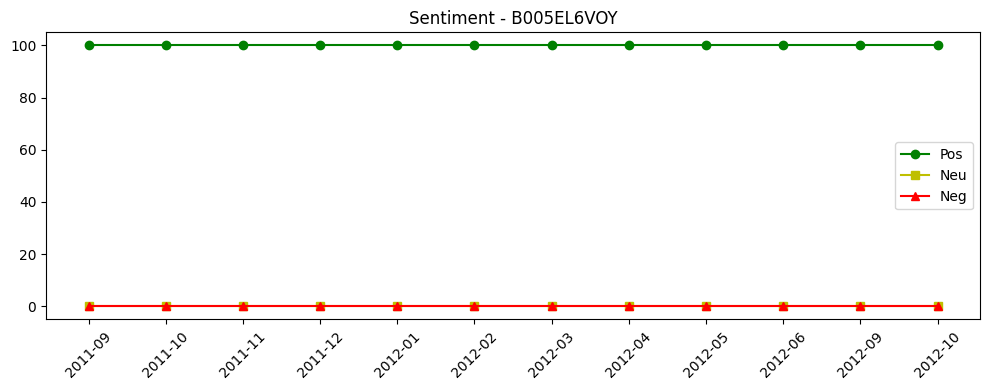

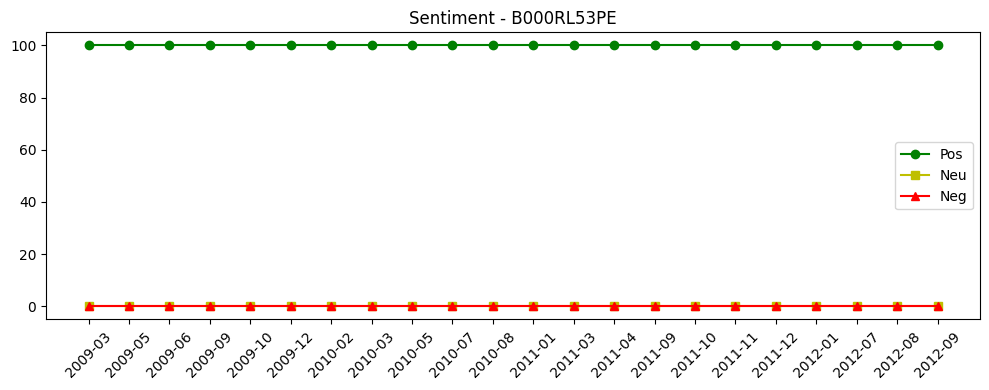

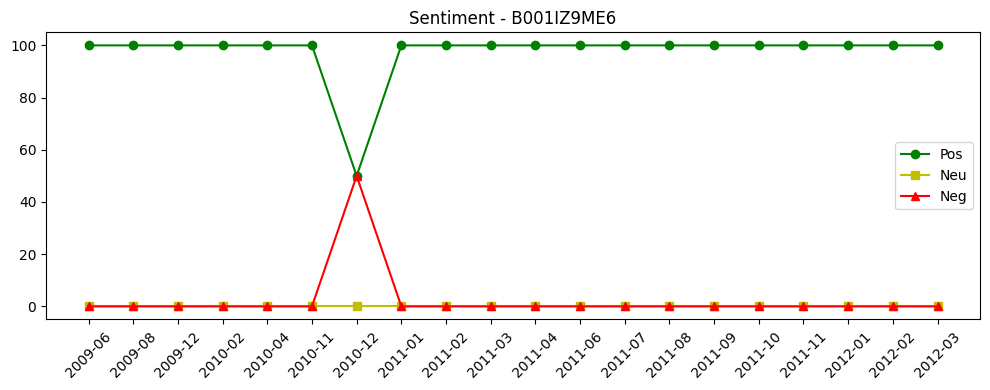

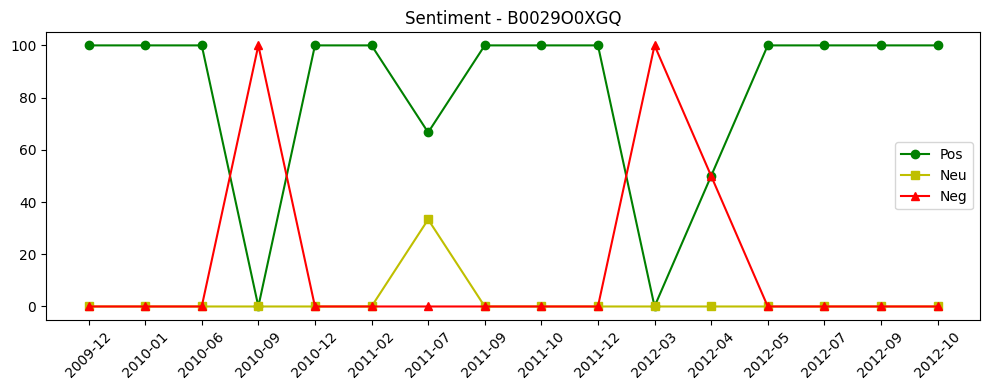

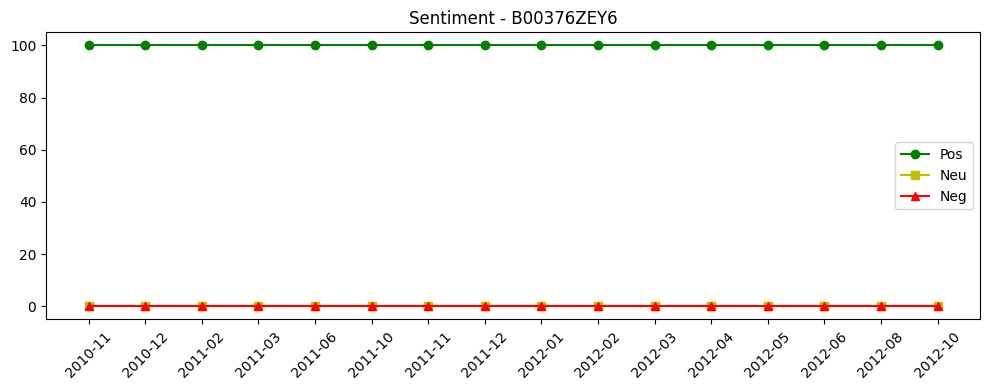

In [26]:
# Charts
for pid in list(proportions.keys())[:5]:
    d = proportions[pid]
    months = sorted(d.keys())

    plt.figure(figsize=(10, 4))
    plt.plot(months, [d[m]['pos']*100 for m in months], 'g-o', label='Pos')
    plt.plot(months, [d[m]['neu']*100 for m in months], 'y-s', label='Neu')
    plt.plot(months, [d[m]['neg']*100 for m in months], 'r-^', label='Neg')
    plt.title(f'Sentiment - {pid}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [29]:
# TEMPORAL TREND VISUALIZATION
print("Anomalies (20% increase in negative reviews):")

for pid, monthsDict in proportions.items(): # d = "'2025-01': {'pos': 0.6, 'neu': 0.3, 'neg': 0.1}""
    months = sorted(monthsDict.keys())

    for i in range(1, len(months)):
        diff = monthsDict[months[i]]['neg'] - monthsDict[months[i-1]]['neg']
        if diff > 0.20:
            print(f"  {pid} - {months[i]}: +{diff*100:.1f}%")

Anomalies (20% increase in negative reviews):
  B001IZ9ME6 - 2010-12: +50.0%
  B0029O0XGQ - 2010-09: +100.0%
  B0029O0XGQ - 2012-03: +100.0%
